# Feature Categorization using Satellite Imagery and Deep Learning

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li><li><span><a href="#Part-1---export-training-data-for-deep-learning" data-toc-modified-id="Part-1---export-training-data-for-deep-learning-2">Part 1 - export training data for deep learning</a></span><ul class="toc-item"><li><span><a href="#Import-ArcGIS-API-for-Python-and-get-connected-to-your-GIS" data-toc-modified-id="Import-ArcGIS-API-for-Python-and-get-connected-to-your-GIS-2.1">Import ArcGIS API for Python and get connected to your GIS</a></span></li><li><span><a href="#Prepare-data-that-will-be-used-for-training-data-export" data-toc-modified-id="Prepare-data-that-will-be-used-for-training-data-export-2.2">Prepare data that will be used for training data export</a></span></li><li><span><a href="#Specify-a-folder-name-in-raster-store-that-will-be-used-to-store-our-training-data" data-toc-modified-id="Specify-a-folder-name-in-raster-store-that-will-be-used-to-store-our-training-data-2.3">Specify a folder name in raster store that will be used to store our training data</a></span></li><li><span><a href="#Export-training-data-using-arcgis.learn" data-toc-modified-id="Export-training-data-using-arcgis.learn-2.4">Export training data using <code>arcgis.learn</code></a></span></li></ul></li><li><span><a href="#Part-2---model-training" data-toc-modified-id="Part-2---model-training-3">Part 2 - model training</a></span><ul class="toc-item"><li><span><a href="#Visualize-training-data" data-toc-modified-id="Visualize-training-data-3.1">Visualize training data</a></span></li><li><span><a href="#Load-model-architecture" data-toc-modified-id="Load-model-architecture-3.2">Load model architecture</a></span></li><li><span><a href="#Train-a-model-through-learning-rate-tuning-and-transfer-learning" data-toc-modified-id="Train-a-model-through-learning-rate-tuning-and-transfer-learning-3.3">Train a model through learning rate tuning and transfer learning</a></span></li><li><span><a href="#Visualize-classification-results-in-validation-set" data-toc-modified-id="Visualize-classification-results-in-validation-set-3.4">Visualize classification results in validation set</a></span></li></ul></li><li><span><a href="#Part-3---inference" data-toc-modified-id="Part-3---inference-4">Part 3 - inference</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5">Conclusion</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-6">Reference</a></span></li></ul></div>

## Introduction

This guide demonstrates the use of deep learning capabilities in ArcGIS to perform feature classification. Specifically, we are going to perform automated damage assessment of homes after the devastating [Woolsey fires](https://en.wikipedia.org/wiki/Woolsey_Fire). This is a critical task in damage claim processing, and using deep learning can speed up the process and make it more efficient. The workflow consists of three major steps: (1) extract training data, (2) train a deep learning **feature classifier** model, (3) deploy the model for inference and create maps. 

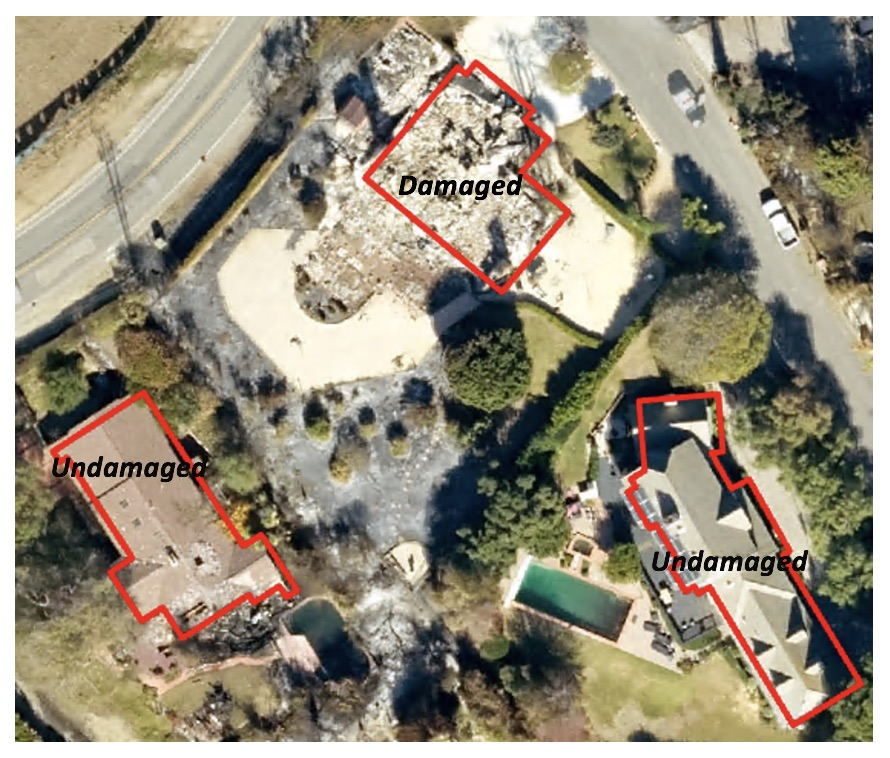
<center>Figure 1. Feature classification example </center>

## Part 1 - export training data for deep learning

To export training data for feature categorization, we need two input data:
- A input raster that contains the spectral bands,
- A feature class that defines the location (e.g. outline or bounding box) each building.

### Import ArcGIS API for Python and get connected to your GIS

In [1]:
from arcgis import GIS

In [2]:
gis = GIS("home")

### Prepare data that will be used for training data export

<Item title:"damage_labelselection_Buffer_100" type:Feature Layer Collection owner:portaladmin>
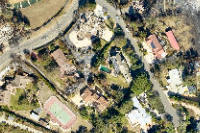

In [3]:
building_label = gis.content.search("damage_labelselection_Buffer_100", item_type='Feature Layer Collection')[0]
building_label

In [8]:
gis2 = GIS("https://ivt.maps.arcgis.com/home")

In [20]:
input_raster_layer = gis2.content.search("111318_USAA_W_Malibu")[0]
input_raster_layer

<Item title:"111318_USAA_W_Malibu" type:Map Image Layer owner:romeroma>

### Specify a folder name in raster store that will be used to store our training data

In [12]:
from arcgis.raster import analytics

ds = analytics.get_datastores(gis=gis)
ds

<DatastoreManager for https://datascienceadv.esri.com/server/admin>

In [13]:
ds.search()

[<Datastore title:"/nosqlDatabases/AGSDataStore_bigdata_bds_4c9tuc3o" type:"nosql">,
 <Datastore title:"/nosqlDatabases/AGSDataStore_nosqldb_tcs_l6mh5mhm" type:"nosql">,
 <Datastore title:"/enterpriseDatabases/AGSDataStore_ds_b6108wk9" type:"egdb">,
 <Datastore title:"/rasterStores/LocalRasterStore" type:"rasterStore">]

In [14]:
rasterstore = ds.get("/rasterStores/LocalRasterStore")
rasterstore

<Datastore title:"/rasterStores/LocalRasterStore" type:"rasterStore">

In [15]:
samplefolder = "feature_classifier_sample"
samplefolder

'feature_classifier_sample'

### Export training data using `arcgis.learn`

Now ready to export training data using the export_training_data() method in arcgis.learn module. In addtion to feature class, raster layer, and output folder, we also need to specify a few other parameters such as tile_size (size of the image chips), strid_size (distance to move each time when creating the next image chip), chip_format (TIFF, PNG, or JPEG), metadata format (how we are going to store those training labels). Note that unlike Unet and object detection, the metadata is set to be `Labeled_Tiles` here. More detail can be found [here](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm). 

Depending on the size of your data, tile and stride size, and computing resources, this opertation can take 15mins~2hrs in our experiment. Also, do not re-run it if you already run it once unless you would like to update the setting.

In [16]:
import arcgis
from arcgis import learn
arcgis.env.verbose = True

In [ ]:
export = learn.export_training_data(input_raster=input_raster_layer,
                                    output_location=samplefolder,
                                    input_class_data=building_label, 
                                    classvalue_field = "classValue",
                                    chip_format="PNG", 
                                    tile_size={"x":600,"y":600}, 
                                    stride_size={"x":0,"y":0}, 
                                    metadata_format="Labeled_Tiles",                                        
                                    context={"startIndex": 0, "exportAllTiles": False, "cellSize": 0.1},
                                    gis = gis)

## Part 2 - model training

If you've already done part 1, you should already have the training chips. Please change the path to your own export training data folder that contains "images" and "labels" folder.

In [4]:
from arcgis.learn import prepare_data, FeatureClassifier

In [5]:
data_path = r'to_your_data_folder'
data = prepare_data(data_path, {1:'Damaged', 0:'Undamaged'}, chip_size=600, batch_size=16)

### Visualize training data
To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualize them.

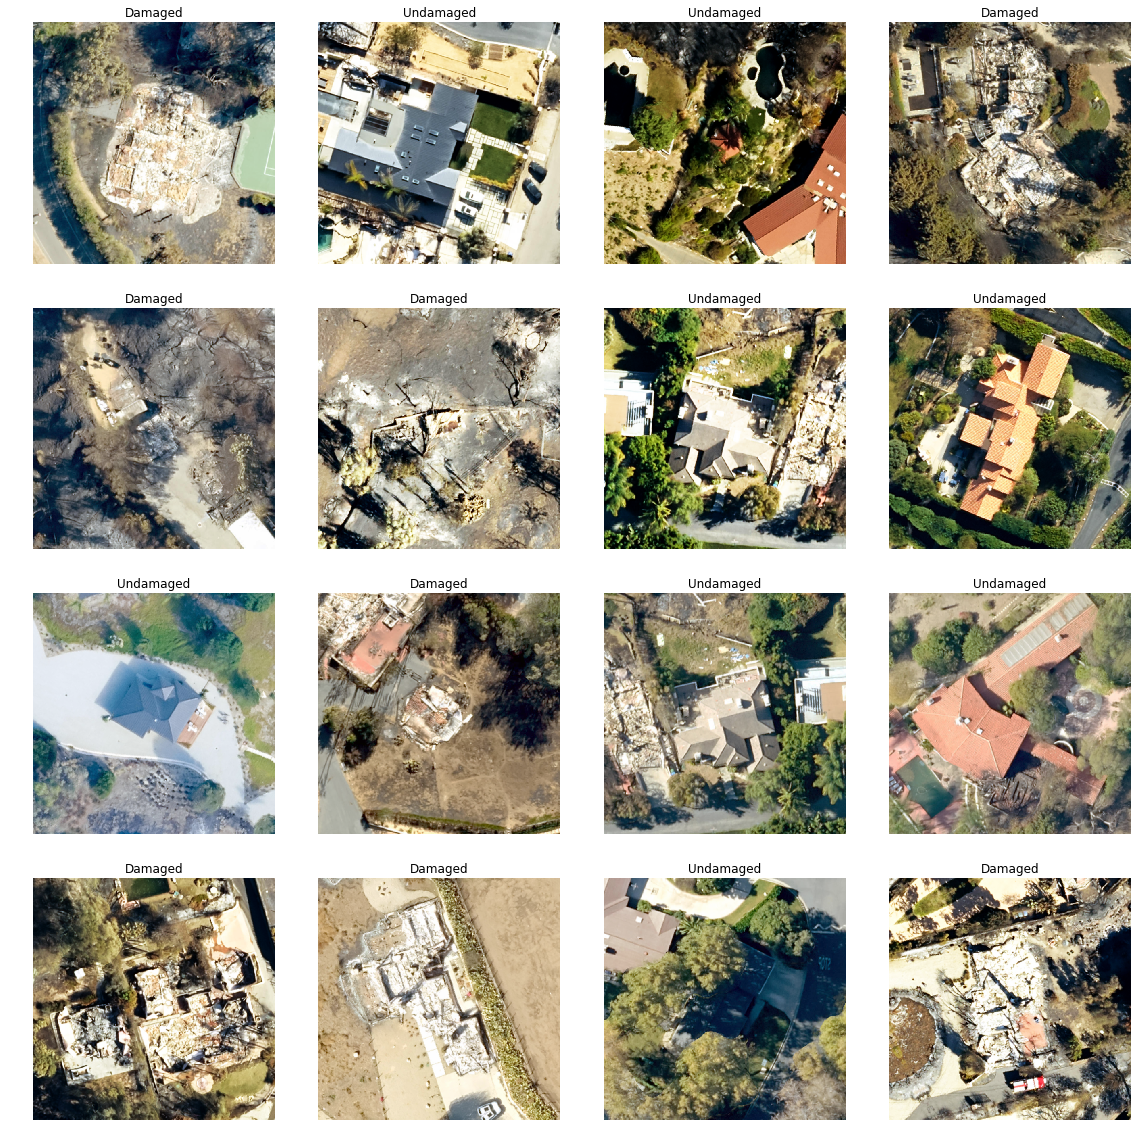

In [3]:
data.show_batch()

### Load model architecture

Now the building classification problem has become a standard image classfication problem. By default `arcgis.learn` uses Resnet34 as its backbone model followed by a softmax layer. 

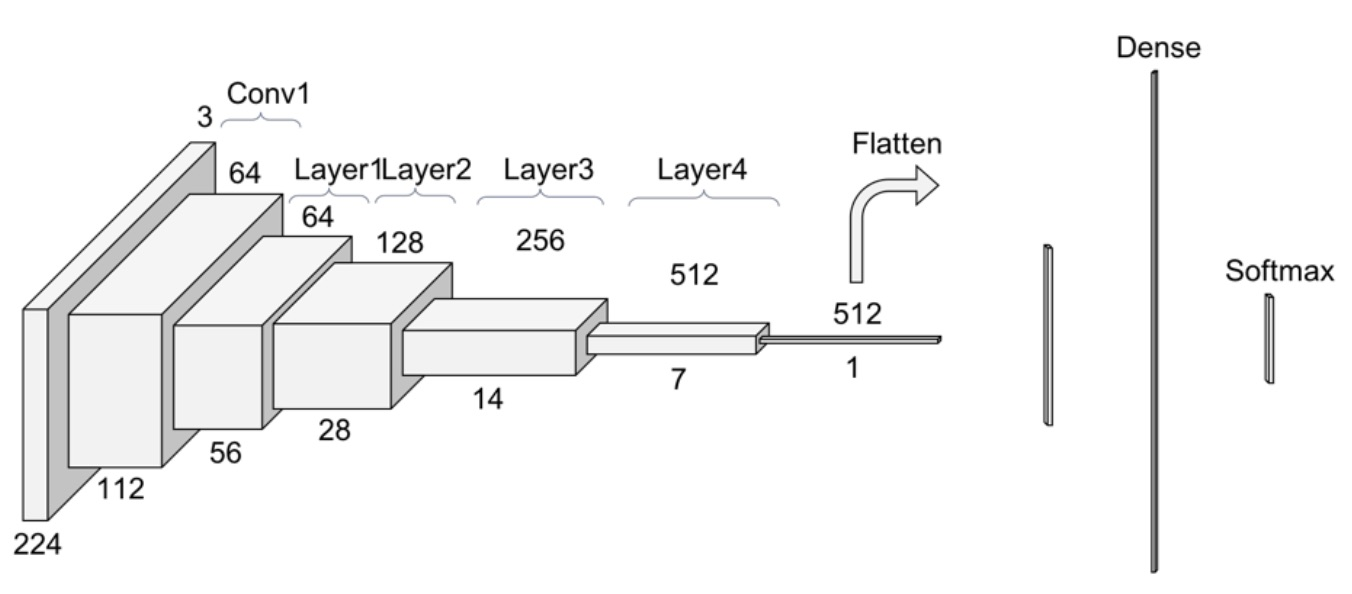
<center>Figure 2. Resnet34 architecture [1] </center>

In [6]:
model = FeatureClassifier(data)

### Train a model through learning rate tuning and transfer learning
[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. Here we explore a range of learning rate to guide us to choose the best one.

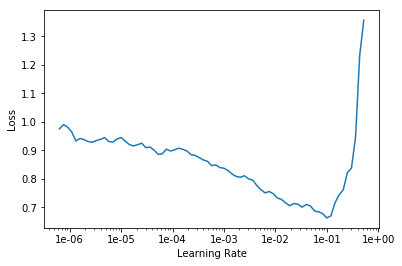

In [5]:
# The users can visualize the learning rate of the model with comparative loss. This case - loss rate decreases, so we are detecting more n more objects as it learns more
model.lr_find()

Based on the learning rate plot above, we can see that the loss going down dramatically at 1e-2. Therefore, we set learning rate to be to 1e-4. Let's start with 10 epochs for the sake of time.

In [6]:
model.fit(epochs=10, lr=1e-2)

### Visualize classification results in validation set
Now we have the model, let's look at how the model performs.

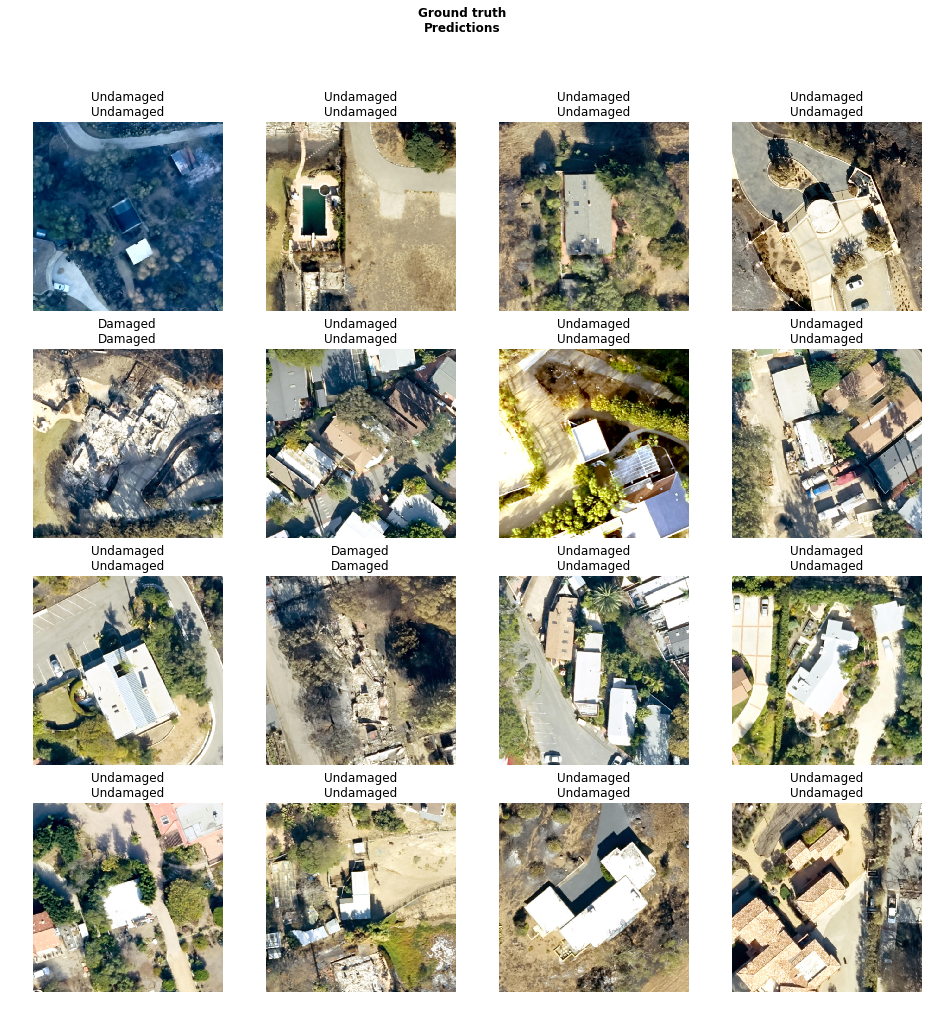

In [9]:
model.show_results(rows=4)

As we can see, with only 10 epochs, we are already seeing reasonable results. Further improvment can be acheived through more sophisticated hyperparameter tuning. Let's save the model for further training or inference later. The model should be saved into a models folder in your folder. By default, it will be saved into your `data_path` that you specified in the very beginning of this notebook.

In [7]:
model.save('model-10')

WindowsPath('D:/feature_classify_folder_100m_buffer/models/model-10')

In [7]:
model.load('model-10')

## Part 3 - inference

Now we have the model ready, let's apply the model to a new feature class with a few new buildings and see how it performs.

<Item title:"inference_layer" type:Feature Layer Collection owner:portaladmin>
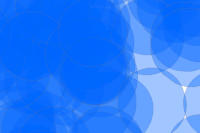

In [14]:
item = gis.content.search("inference_layer", item_type='Feature Layer Collection')[0]
item

In order to classify these new buildings, we can first use `export_training_data()` with this new feature class as an input to generate image chips. Unlike object detection and pixel-based classification, we can use `classify_features()` directly without publishing or installing the model.

In [15]:
inference_data = r'to_your_inference_data_folder' # point to the output directory of export training data using inference layer
model.classify_features(item.layers[0], inference_data, 'id_building', 'predict', 'conf')

True

We can load the inference layer into a spatially enabled dataframe to examine the inference result.

In [23]:
import pandas as pd
from arcgis.features import GeoAccessor, GeoSeriesAccessor

sdf = pd.DataFrame.spatial.from_layer(item.layers[0])
sdf[['bld_id', 'usetype', 'ground_truth','predict', 'conf']].head(10)

bld_id      usetype ground_truth    predict                conf
0  312778833124  Residential      DAMAGED    Damaged  0.9997335076332092
1  312745833781  Residential    Undamaged  Undamaged  0.9998792409896851
2  313750833138  Residential    Undamaged  Undamaged   0.999637246131897
3  313308832529  Residential    Undamaged  Undamaged  0.9999970197677612
4  313868832780  Residential    Undamaged  Undamaged  0.9994100332260132
5  313085833616  Residential      DAMAGED    Damaged  0.9990701079368591
6  313200832345  Residential      DAMAGED    Damaged  0.9996880292892456
7  313100832645  Residential      DAMAGED    Damaged  0.9985143542289734
8  313462833517  Residential    Undamaged  Undamaged  0.9999239444732666
9  313189833045  Residential    Undamaged  Undamaged  0.9999997615814209

As we can see, all sample buildings are classified correctly with high confidence.

## Reference

[1] Ruiz Pablo, Understanding and Visualizing ResNets,  https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8, Accessed 2 September 2019.